In [78]:
%reset -f
import numpy as np

#plotting
import matplotlib.pyplot as plt

In [79]:
#import matplotlib.style as style
#style.use("grayscale")
%matplotlib inline

#units
from astropy import units as u

#POPPY
import poppy
import sys
from poppy import fresnel


from poppy.poppy_core import _PUPIL, _IMAGE, _INTERMED

#logging
import logging
_log = logging.getLogger('poppy')
_log.setLevel(logging.DEBUG)

#make logging work in IPYTHON:
try:
    from IPython.core.debugger import Tracer; stop = Tracer()
except:
    pass

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')







fudge_factor = 3;

In [80]:
class sinc_squared_occulter(poppy.AnalyticOpticalElement):

    def __init__(self, name='occulter', **kwargs):
        poppy.AnalyticOpticalElement.__init__(self, name=name, **kwargs)
        
    def getPhasor(self, wave):
        hwhm_sinc_squared = 1.7996
        hwhm = 2.5
        pupil_ratio = (1.0/wave.oversample)/fudge_factor
        y, x = poppy_wavefront.coordinates()
        r = (np.sqrt(x**2 + y**2)/poppy_wavefront.pixelscale) * pupil_ratio * hwhm_sinc_squared/hwhm
        theta = np.arctan2(y,x)
        amp = 1 - (np.sinc(r))**2
        return amp

In [97]:
class phase_aberation_inducer(poppy.AnalyticOpticalElement):

    def __init__(self, name=None, radius=1.0, pad_factor=1.0, map_adjust = 1e5, **kwargs):
        try:
            self.radius = float(radius)
        except ValueError:
            raise TypeError("Argument 'radius' must be the radius of the pupil in meters")
            
        if name is None:
            name = "Circle, radius=%.2f m" % radius
        super(phase_aberation_inducer, self).__init__( name=name, planetype=_PUPIL, **kwargs)
        # for creating input wavefronts - let's pad a bit:
        self.pupil_diam = pad_factor * 2 * self.radius
        self.map_adjust = map_adjust

    def __load_aberation_map_interpolator__(self,radius):
        from scipy.interpolate import InterpolatedUnivariateSpline
        dataFile = 'new_circular_error_map.dat'
        fd = open(dataFile,'rb')
        fd.seek(0,0)
        nmap = np.fromfile(fd, dtype = np.long, count = 1)[0]
        fd.seek(4,0)
        rmap = np.fromfile(fd, dtype = np.float64, count = nmap) * radius
        zmap = np.fromfile(fd, dtype = np.float64, count = nmap)
        fd.close()
        f = InterpolatedUnivariateSpline(rmap, zmap, k=4)
        return f
    
    def getPhasor(self, wave):
        if not isinstance(wave, poppy.Wavefront):  # pragma: no cover
            raise ValueError("CircularAperture getPhasor must be called with a Wavefront "
                             "to define the spacing")
        assert (wave.planetype != _IMAGE)
        

        map_adjust = 1e5

        y, x = self.get_coordinates(wave)
        r = np.sqrt(x ** 2 + y ** 2)*poppy_wavefront.pixelscale
        del x
        del y
        interpolator = self.__load_aberation_map_interpolator__(self.radius)
        self.aberation_map = self.map_adjust*interpolator(r)
        w_outside = np.where(r > self.radius)
        del r
        self.transmission = np.ones(wave.shape) + np.exp(1.j * 2 * np.pi * self.aberation_map)
        self.transmission[w_outside] = 0
        return self.transmission

In [98]:
def poppy_system(wavefront, use_occulter=True):
    
    diam = 0.025*u.m
    fl = 0.7*u.m
    
    pupil_ratio = (1.0/wavefront.oversample)/fudge_factor
    
    wavefront *= poppy.CircularAperture(radius=diam.value/2.0)
    wavefront *= phase_aberation_inducer(radius=diam.value/2.0)
    wavefront.apply_lens_power(fresnel.GaussianLens(fl, name='M1'))
    wavefront *= poppy.CircularAperture(radius=diam.value/2.0)
    

    wavefront.propagate_fresnel(fl,display_intermed=False)
    
    
    if (use_occulter): wavefront *= sinc_squared_occulter(name='Occulter')
#     wavefront *= poppy.CircularAperture(radius=250.0*pupil_ratio*wavefront.pixelscale)
    
    
    wavefront.propagate_fresnel(fl,display_intermed=False)
    
    
    wavefront.apply_lens_power(fresnel.GaussianLens(fl, name='M2'))
    wavefront *= poppy.CircularAperture(radius=1.6*diam.value/2)

    
    wavefront.propagate_fresnel(2*fl,display_intermed=False)

    
    wavefront *= poppy.CircularAperture(radius=0.53*diam.value/2, name='Lyot Stop')
    wavefront.apply_lens_power(fresnel.GaussianLens(fl, name='Lyot Stop'))
    
    
    wavefront.propagate_fresnel(fl,display_intermed=False)
    
    return wavefront

DEBUG:poppy:Padded WF array for oversampling by 8, to (2048, 2048).
DEBUG:poppy:Padded WF array for oversampling by 8, to (2048, 2048).
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: Circle, radius=0.01 m (Analytic)
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: Circle, radius=0.01 m (Analytic)
DEBUG:poppy:Initialized: M1, fl =7.00e-01 m
DEBUG:poppy:------ Applying Lens: M1 ------
DEBUG:poppy:  Pre-Lens Beam Parameters: w_0:1.250e-02 m, z_w0=0.000e+00 m
z=0.000e+00 m, z_R=9.817e+02 m
DEBUG:poppy:  Beam radius at M1 =1.25e-02 m
DEBUG:poppy: input flat wavefront and M1 has output beam curvature of =-7.00e-01 m
DEBUG:poppy:M1 has a curvature of =-7.00e-01 m
DEBUG:poppy:M1 has a curved output wavefront, with waist at 0.699999644128 m
DEBUG:poppy:Post Optic Parameters:w_0:8.913e-06 m, z_w0=7.000e-01 m
z=0.000e+00 m, z_R=4.991e-04 m
DEBUG:poppy:Set output beam focal length to 0.7 m
DEBUG:poppy:Inside Rayleigh distance to Outside Rayleigh distance.
DEBUG:poppy:Applying spheric

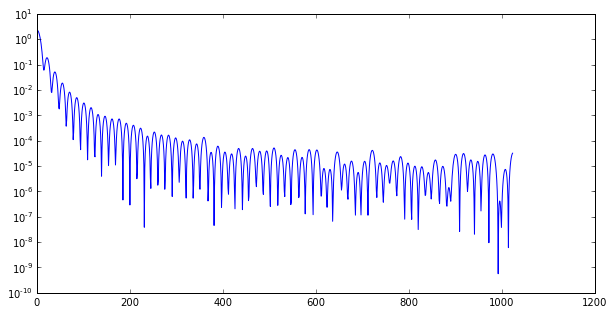

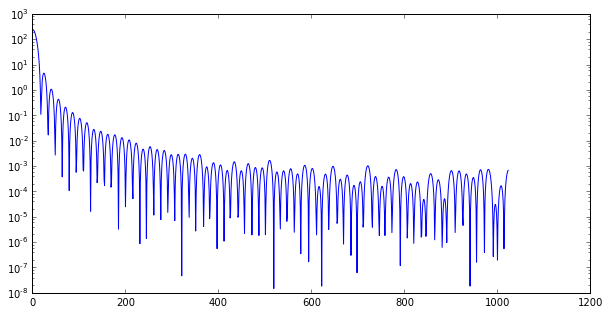

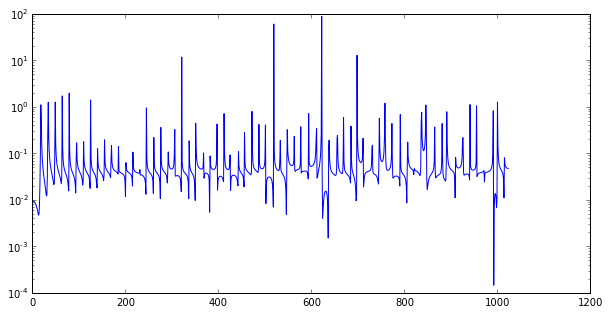

In [100]:
#Using the same simple setup used in TDEM milestone 1 report, Appendix B: Verification of PROPER (p. 26)
#Ref Figure 9 for the setup, Ref p. 27 for dimensions

lam = 500e-9

osamp=8 #oversampling factor

n=256

beam_diameter = 0.025*u.m

#intialize wavefront
poppy_field = fresnel.FresnelWavefront(beam_radius=beam_diameter/2, wavelength=lam, npix=n, oversample=osamp)
poppy_psf = fresnel.FresnelWavefront(beam_radius=beam_diameter/2, wavelength=lam, npix=n, oversample=osamp)

poppy_field = poppy_system(poppy_field,use_occulter=True)
poppy_psf = poppy_system(poppy_psf,use_occulter=False)

poppy_field_profile = poppy_field.intensity[osamp*n/2:,osamp*n/2]
poppy_psf_profile = poppy_psf.intensity[osamp*n/2:,osamp*n/2]

poppy_contrast_profile = poppy_field_profile / poppy_psf_profile





plt.figure(figsize=(10,5))
plt.semilogy(poppy_field_profile)
plt.show()

plt.figure(figsize=(10,5))
plt.semilogy(poppy_psf_profile)
plt.show()

plt.figure(figsize=(10,5))
plt.semilogy(poppy_contrast_profile)
plt.show()






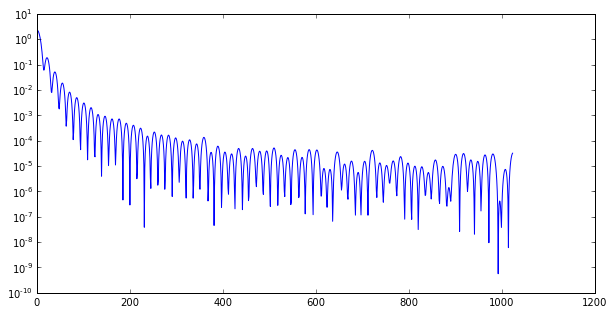

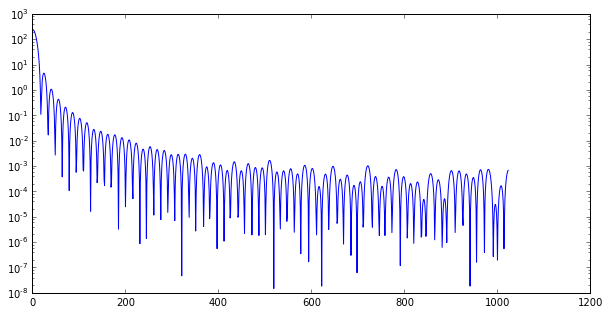

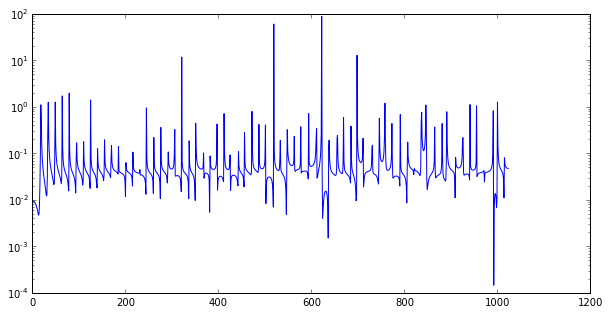

In [101]:
plt.figure(figsize=(10,5))
plt.semilogy(poppy_field_profile)
plt.show()

plt.figure(figsize=(10,5))
plt.semilogy(poppy_psf_profile)
plt.show()

poppy_contrast_profile = poppy_field_profile / poppy_psf_profile

plt.figure(figsize=(10,5))
plt.semilogy(poppy_contrast_profile)
plt.show()